In [ ]:
!pip install qiskit
!pip install pylatexenc--upgrade
!pip install retworkx
#!pip install numpy --upgrade
from IPython.display import clear_output
clear_output()

In [31]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.circuit.library import ZGate, XGate
from qiskit.extensions import UnitaryGate
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.operators import WeightedPauliOperator, MatrixOperator, op_converter
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
#from qiskit.quantum_info.operators import Operator

import numpy as np
import scipy
import networkx as nx
from matplotlib import pyplot as plt
import copy

# Generating the Graph

Let's generate a 4-node graph with randomized true weights and bias. Since each node is represented as a single qubit, we need 4 qubits for this graph.

In [2]:
# Define the number of qubits

num_qubit = 4
qubits = range(num_qubit)

Edges: [(0, 1), (0, 2), (0, 3)]


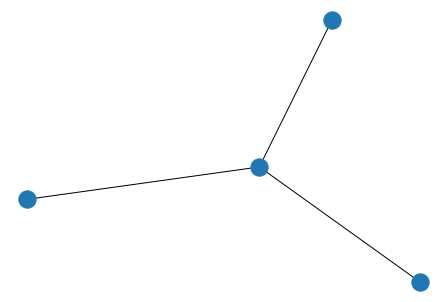

In [3]:
# Generating the graph

ising_graph = nx.star_graph(num_qubit-1)
print("Edges:", ising_graph.edges)
nx.draw(ising_graph)

In [4]:
# Set the random seed

rng = np.random.default_rng(seed=2021)

In [5]:
# Initialize the true weights and bias

true_weights = rng.random(size=len(ising_graph.edges)) - 0.5
true_bias = rng.random(size=num_qubit) - 0.5

print("True Weights:", true_weights)
print("True Bias", true_bias)

True Weights: [0.25694783 0.44138187 0.09246304]
True Bias [-0.18115829  0.12607384 -0.46448613 -0.24787304]


# Creating the Hamiltonian Matrix

From the generated graph, we then construct the ising model Hamiltonian matrix.

In [6]:
def create_hamiltonian_matrix(n_qubits, graph, weights, bias):

    full_matrix = np.zeros((2 ** n_qubits, 2 ** n_qubits))

    # Creates the interaction component of the Hamiltonian
    for i, edge in enumerate(graph.edges):
        interaction_term = 1
        for qubit in range(0, n_qubits):
            if qubit in edge:
                interaction_term = np.kron(interaction_term, np.array(ZGate().to_matrix(), dtype=float))
            else:
                interaction_term = np.kron(interaction_term, np.identity(2))
        full_matrix += weights[i] * interaction_term

    # Creates the bias components of the matrix
    for i in range(0, n_qubits):
        z_term = x_term = 1
        for j in range(0, n_qubits):
            if j == i:
                z_term = np.kron(z_term, np.array(ZGate().to_matrix(), dtype=float))
                x_term = np.kron(x_term, np.array(XGate().to_matrix(), dtype=float))
            else:
                z_term = np.kron(z_term, np.identity(2))
                x_term = np.kron(x_term, np.identity(2))
        full_matrix += bias[i] * z_term + x_term

    return full_matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


Hamiltonian Matrix Visualization


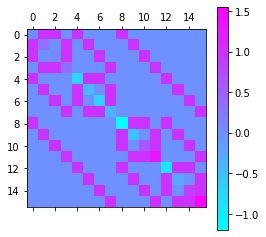

In [7]:
# Prints a visual representation of the Hamiltonian matrix
H_matrix = create_hamiltonian_matrix(num_qubit, ising_graph, true_weights, true_bias)

print("Hamiltonian Matrix Visualization")
plt.matshow(H_matrix, cmap="cool")
plt.colorbar()
plt.show()

Let's calculate the true ground state energy (the lowest eigenvalue) of this Hamiltonian matrix.

In [8]:
ground_state_energy = np.real_if_close(min(np.linalg.eig(H_matrix)[0]))
print("Ground State Energy:", ground_state_energy)

Ground State Energy: -4.197624303542111


# Preparing the Quantum Data with VQE

To train the QGRNN, we have to prepare the quantum state as the data. This low energy quantum state can be obtained by using VQE.

Convert the Hamiltonian matrix into quantum operator.

In [9]:
H_operator = op_converter.to_weighted_pauli_operator(MatrixOperator(H_matrix))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/qiskit/aqua/operators/legacy/op_converter.py:90: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  num_processes=aqua_globals.num_processes)


To make sure, let's check this operator minimum eigenvalue. It should be the same as the minimum eigenvalue of the Hamiltonian matrix.

In [30]:
eig_vals = NumPyEigensolver(H_operator).run()
print("Minimum Eigenvalue:", np.real_if_close(min(eig_vals['eigenvalues'])))

Minimum Eigenvalue: -4.197624303542115


Now, let's run the VQE with SLSQP optimizer.<br>
Remember that we want the low energy state but NOT the gound state. We make the number of iteration small to prevent the VQE from reaching the ground state. The eigenvalue from VQE should be a little bit higher than the ground state energy.

In [36]:
opt = SLSQP(maxiter=5)

backend = Aer.get_backend("statevector_simulator")

vqe=VQE(operator=H_operator, optimizer=opt)
vqe_result=vqe.run(backend)

print("VQE Eigenvalue:", np.real_if_close(vqe_result['eigenvalue']))

VQE Eigenvalue: -4.112441594328477


By using the optimized VQE circuit, we can now obtain the low energy quantum state.

In [37]:
#vqe.get_optimal_circuit().draw()
low_energy_state = vqe.get_optimal_vector()
print("Low Energy State:", low_energy_state)

Low Energy State: [-0.32086065+0.j  0.20076652+0.j  0.16915614+0.j -0.12905635+0.j
  0.39873232+0.j -0.30236909+0.j -0.22083949+0.j  0.15331484+0.j
  0.33739082+0.j -0.29700463+0.j -0.17093072+0.j  0.15162227+0.j
 -0.30793473+0.j  0.31081197+0.j  0.1576565 +0.j -0.13508318+0.j]


In [47]:
# Sanity check, will be deleted in the final notebook

print(np.real_if_close(np.conj(vqe.get_optimal_vector())@H_matrix@vqe.get_optimal_vector()))
print(np.conj(vqe.get_optimal_vector())@vqe.get_optimal_vector())

import math
math.isclose(np.sum(np.absolute(np.kron(low_energy_state,low_energy_state)) ** 2), 1.0,
                                abs_tol=1e-11)

-4.112441594328477
(1.0000000000000002+0j)


True

We also need the time-evolved low energy states from the initial low energy state that we obtained from VQE previously. This can be done by converting the Hamiltonian matrix into unitary operator.

In [46]:
def state_evolve(circuit, hamiltonian, qubits, time):

    U = scipy.linalg.expm(-1j * hamiltonian * time)
    U_gate = UnitaryGate(U, label='evolved_unitary_'+str(time))
    circuit.unitary(U_gate, qubits)
    
    return circuit

# Preparing the QGRNN Circuit

The first component that we need is the QGRNN layer. We can construct an ansatz that consists of RX, RZ, and RZZ gate with random initial parameters since the Hamiltonian in this example only consists of X, Z, and ZZ gate.

In [48]:
def qgrnn_layer(circuit, weights, bias, qubits, graph, trotter_step):

    # Applies a layer of RZZ gates (based on a graph)
    for i, edge in enumerate(graph.edges):
        circuit.rzz(2 * weights[i] * trotter_step, edge[0], edge[1])

    # Applies a layer of RZ gates
    for i, qubit in enumerate(qubits):
        circuit.rz(2 * bias[i] * trotter_step, qubit)

    # Applies a layer of RX gates
    for qubit in qubits:
        circuit.rx(2 * trotter_step, qubit)
        
    return circuit

The second component we need is a circuit to perform SWAP test. At the end of the QGRNN circuit, we check how similar the quantum state being produced with the quantum data. This similarity can be measured by calculating their overlap with SWAP test.

In [49]:
def swap_test(circuit, control, register1, register2):

    circuit.h(control)
    for reg1_qubit, reg2_qubit in zip(register1, register2):
        circuit.cswap(control, reg1_qubit, reg2_qubit)
    circuit.h(control)
    
    return circuit

Let's generate the initial guess of the graph and its weights & bias. We start from a complete graph and assume that all qubits are connected to each other.

Edges: [(4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


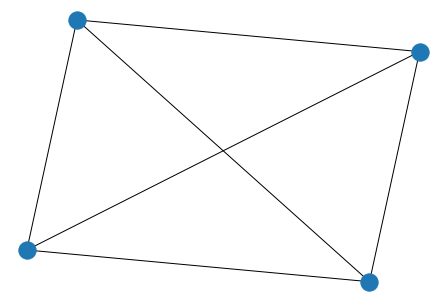

In [53]:
# Defines some fixed values

reg_data = tuple(range(num_qubit))  # First qubit register for quantum data
reg_qgrnn = tuple(range(num_qubit, 2 * num_qubit))  # Second qubit register for QGRNN

control = 2 * num_qubit  # Index of control qubit
trotter_step = 0.01  # Trotter step size

# Defines the initial interaction graph

initial_ising_graph = nx.complete_graph(reg_qgrnn)

print("Edges:", initial_ising_graph.edges)
nx.draw(initial_ising_graph)

In [54]:
# Initialize random weights and bias

weights = rng.random(size=len(initial_ising_graph.edges)) - 0.5
bias = rng.random(size=num_qubit) - 0.5
trainable_params = np.concatenate((weights, bias))

initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

print(trainable_params)

[-0.01498634 -0.19873312  0.22195094  0.42989066  0.40823581 -0.41504144
 -0.22963383  0.47168176 -0.23984993  0.30052031]


Putting everything together ...

In [57]:
def qgrnn(param_weights, param_bias, time=None):

    circuit = QuantumCircuit(2*num_qubit+1, 1)
    
    # Prepares the low energy state in the two registers
    circuit.initialize(np.kron(low_energy_state, low_energy_state), reg_data + reg_qgrnn)

    # Evolves the first qubit register with the time-evolution circuit to
    # prepare a piece of quantum data
    circuit = state_evolve(circuit, H_matrix, reg_data, time)

    # Applies the QGRNN layers to the second qubit register
    depth = time / trotter_step  # P = t/Delta
    for _ in range(0, int(depth)):
        circuit = qgrnn_layer(circuit, param_weights, param_bias, reg_qgrnn, initial_ising_graph, trotter_step)

    # Applies the SWAP test between the registers
    circuit = swap_test(circuit, control, reg_data, reg_qgrnn)

    # Measure the circuit
    circuit.measure([control], [0])
    
    return circuit

In [58]:
qgrnn(initial_weights, initial_bias, time=0.02).draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
q_8: »
     »
c: 1/»
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# The Cost Function

The goal is to train the QGRNN circuit to reproduce the Hamiltonian matrix. This is achieved when the quantum state produced by QGRNN completely overlap with the quantum data. This means we want to maximize the overlap value from the SWAP test. Or, in another word, we want to minimize the negative of this value.

The Z expectation value of SWAP test is equal to this overlap.

In [60]:
def z_exp(circuit, shots=10000):
    backend = Aer.get_backend('aer_simulator_statevector')

    job = backend.run(circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)
    
    try:
        exp_0 = counts['0']/shots
    except:
        exp_0 = 0
        
    try:
        exp_1 = counts['1']/shots
    except:
        exp_1 = 0
    
    exp = exp_0 - exp_1
    
    return exp

In [61]:
N = 15  # The number of pieces of quantum data that are used for each step
max_time = 0.1  # The maximum value of time that can be used for quantum data

In [65]:
def cost_function(params):

    # Randomly samples times at which the QGRNN runs
    times_sampled = rng.random(size=N) * max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = z_exp(qgrnn(params[:len(initial_ising_graph.edges)], params[len(initial_ising_graph.edges):], time=dt))
        total_cost += -1 * result

    return total_cost / N

In [63]:
# Sanity check, will be deleted in the final notebook

backend = Aer.get_backend('aer_simulator_statevector')
job = backend.run(qgrnn(trainable_params[:len(initial_ising_graph.edges)], trainable_params[len(initial_ising_graph.edges):], time=0.09716818), shots=10000)
result = job.result()
counts = result.get_counts(0)
counts

{'0': 9936, '1': 64}

# Training the QGRNN

In [71]:
# Sanity check
cost_function(trainable_params)

-0.9963333333333335

Let's optimize the circuit's parameters (weights and bias) with L-BFGS optimizer.

In [72]:
opt_params = scipy.optimize.minimize(fun=cost_function, x0=trainable_params, tol=1e-12,
                                     method='L-BFGS-B',
                                    #args=(),
                                    options={'maxiter':5000, 'ftol':1e-12})

print(opt_params)

      fun: -0.9961466666666666
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([      0.        ,  114666.66666667, -108000.        ,
        194666.66666667,  122666.66666666,  154666.66666664,
         18666.66666667, -112000.00000001,   10666.66666665,
         81333.33333332])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 286
      nit: 3
   status: 0
  success: True
        x: array([-0.01498508, -0.19873244,  0.22195127,  0.42989113,  0.4082361 ,
       -0.41504067, -0.22963286,  0.47168226, -0.23985003,  0.30052158])


With the learned parameters, we construct a visual representation
of the Hamiltonian to which they correspond and compare it to the
true Hamiltonian, and the initial guessed Hamiltonian.

In [73]:
trained_weights = opt_params['x'][:len(initial_ising_graph.edges)]
trained_bias = opt_params['x'][len(initial_ising_graph.edges):]

weights.shape, bias.shape

((6,), (4,))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


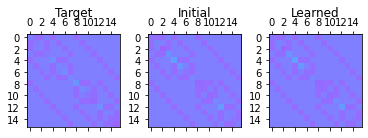

In [74]:
H_matrix_trained = create_hamiltonian_matrix(
    num_qubit, nx.complete_graph(num_qubit), trained_weights, trained_bias
)

H_matrix_initial = create_hamiltonian_matrix(
    num_qubit, nx.complete_graph(num_qubit), initial_weights, initial_bias
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6, 6))

axes[0].matshow(H_matrix, vmin=-7, vmax=7, cmap="cool")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(H_matrix_initial, vmin=-7, vmax=7, cmap="cool")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(H_matrix_trained, vmin=-7, vmax=7, cmap="cool")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()